In [1]:
low_RAM_mode = True
very_low_RAM = False  #If you have <3GB RAM, set BOTH to true

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [11]:
if not low_RAM_mode:
    # a lot of ram
    df = pd.read_csv("avito_train.tsv",sep='\t')
else:
    #aroung 4GB ram
    df = pd.read_csv("/media/max2/Ubuntu 16.0/avito_train_1kk.tsv",sep='\t')

In [12]:
print df.shape, df.is_blocked.mean()
df[:5]

(1204949, 13) 0.228222107326


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0,1,0,0,0,1.43


In [13]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.228222107326
Count: 1204949


In [14]:
df = pd.concat([df[df.is_blocked == 0].sample(125000), df[df.is_blocked == 1].sample(125000)])

In [15]:
print "Blocked ratio",df.is_blocked.mean()
print "Count:",len(df)

Blocked ratio 0.5
Count: 250000


In [16]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print "All tests passed"

All tests passed


In [17]:
RegexpTokenizer?

Object `RegexpTokenizer` not found.


In [18]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#Dictionary of tokens
token_counts = Counter()

#All texts
all_texts = np.hstack([df.description.values,df.title.values])


#Compute token frequencies
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.decode('utf8').lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

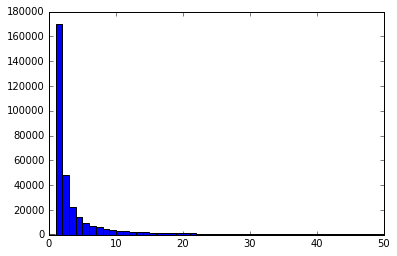

In [19]:
#Word frequency distribution, just for kicks
_=plt.hist(token_counts.values(),range=[0,50],bins=50)

In [20]:
#Select only the tokens that had at least 10 occurences in the corpora.
#Use token_counts.

min_count = 10
tokens = [x for x in token_counts.keys() if token_counts[x] > min_count]

In [21]:
token_to_id = {t:i+1 for i,t in enumerate(tokens)}
null_token = "NULL"
token_to_id[null_token] = 0

In [22]:
print "# Tokens:",len(token_to_id)
if len(token_to_id) < 30000:
    print "Alarm! It seems like there are too few tokens. Make sure you updated NLTK and applied correct thresholds -- unless you now what you're doing, ofc"
if len(token_to_id) > 1000000:
    print "Alarm! Too many tokens. You might have messed up when pruning rare ones -- unless you know what you're doin' ofc"

# Tokens: 52502


In [23]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.decode('utf8').lower()
        tokens = tokenizer.tokenize(s)
        token_ids = map(lambda token: token_to_id.get(token,0), tokens)[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [24]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

In [25]:
print "Размер матрицы:",title_tokens.shape
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print title,'->', tokens[:10],'...'

Размер матрицы: (250000, 15)
Сниму 1-к квартиру -> [49828 48954 49954 51482     0     0     0     0     0     0] ...
Sera Витамины для рыб 100 мл Фиштамин -> [    0 41278 12330 33973 34680 30636     0     0     0     0] ...
Шубка норковая 70 см -> [19448  6375 22465 18122     0     0     0     0     0     0] ...


In [26]:
#All numeric features
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]

In [27]:
print df[["category","subcategory"]].head()

                    category                subcategory
350601          Недвижимость                   Квартиры
413958              Животные                   Аквариум
815690           Личные вещи  Одежда, обувь, аксессуары
1147025  Бытовая электроника    Оргтехника и расходники
1108673         Недвижимость                   Квартиры


In [28]:
from sklearn.feature_extraction import DictVectorizer

categories = []
data_cat_subcat = df[["category","subcategory"]].values

categories = [ {"category":x[0], "subcategory":x[1]} for x in data_cat_subcat]

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot,columns=vectorizer.feature_names_)

In [29]:
df_non_text = pd.merge(
    df_numerical_features,cat_one_hot,on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

In [30]:
#Target variable - whether or not sample contains prohibited material
target = df.is_blocked.values.astype('int32')
#Preprocessed titles
title_tokens = title_tokens.astype('int32')
#Preprocessed tokens
desc_tokens = desc_tokens.astype('int32')

#Non-sequences
df_non_text = df_non_text.astype('float32')

In [31]:
from sklearn.cross_validation import train_test_split

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = train_test_split(\
title_tokens, desc_tokens, df_non_text, target)

In [4]:
save_prepared_data = False #save
read_prepared_data = True #load


#but not both at once
assert not (save_prepared_data and read_prepared_data)

if save_prepared_data:
    data_tuple = (title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts)
    print "Saving preprocessed data (may take up to 3 minutes)"

    import pickle
    with open("preprocessed_data.pcl",'w') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'w') as fout:
        pickle.dump(token_to_id,fout)

    print "готово"
    
elif read_prepared_data:
    print "Reading saved data..."
    
    import pickle
    
    with open("preprocessed_data.pcl",'r') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'r') as fin:
        token_to_id = pickle.load(fin)
        
    #Re-importing libraries to allow staring noteboook from here
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
   
    print "done"

Reading saved data...
done


In [5]:
import lasagne
from theano import tensor as T
import theano

In [6]:
title_token_ids = T.matrix("title_token_ids",dtype='int32')
desc_token_ids = T.matrix("desc_token_ids",dtype='int32')
categories = T.matrix("categories",dtype='float32')
target_y = T.ivector("is_blocked")

In [7]:
title_inp = lasagne.layers.InputLayer((None,title_tr.shape[1]),input_var=title_token_ids)
descr_inp = lasagne.layers.InputLayer((None,desc_tr.shape[1]),input_var=desc_token_ids)
cat_inp = lasagne.layers.InputLayer((None,nontext_tr.shape[1]), input_var=categories)

In [72]:
# Descriptions
N_HIDDEN = 64
DROPOUT = 0.15
#word-wise embedding. We recommend to start from some 64 and improving after you are certain it works.
descr_nn_0 = lasagne.layers.EmbeddingLayer(descr_inp, input_size=len(token_to_id)+1, output_size=64)
descr_nn_1 = lasagne.layers.LSTMLayer(descr_nn_0, N_HIDDEN,\
                nonlinearity=lasagne.nonlinearities.tanh)

# Titles
title_nn_0 = lasagne.layers.EmbeddingLayer(title_inp, input_size=len(token_to_id)+1, output_size=64)
title_nn_1 = lasagne.layers.LSTMLayer(title_nn_0, N_HIDDEN,\
                nonlinearity=lasagne.nonlinearities.tanh)

# Non-sequences
cat_nn = lasagne.layers.DenseLayer(cat_inp, N_HIDDEN, W = lasagne.init.Normal(), nonlinearity=\
                lasagne.nonlinearities.tanh)

x,y, xx, yy = lasagne.layers.get_output_shape(descr_nn_1)[1], lasagne.layers.get_output_shape(descr_nn_1)[2],\
                lasagne.layers.get_output_shape(title_nn_1)[1], lasagne.layers.get_output_shape(title_nn_1)[2]
print x,y,xx,yy
title_nn_1 = lasagne.layers.ReshapeLayer(title_nn_1, (-1, xx*yy))
descr_nn_1 = lasagne.layers.ReshapeLayer(descr_nn_1, (-1, x*y))

150 64 15 64


In [73]:
print(lasagne.layers.get_output_shape(title_nn_1))
print(lasagne.layers.get_output_shape(descr_nn_1))
print(lasagne.layers.get_output_shape(cat_nn))

(None, 960)
(None, 9600)
(None, 64)


In [74]:
nn = lasagne.layers.concat([descr_nn_1, title_nn_1, cat_nn])                                 
nn = lasagne.layers.DenseLayer(nn, 10, nonlinearity=lasagne.nonlinearities.sigmoid)
nn = lasagne.layers.DropoutLayer(nn,p=DROPOUT)
nn = lasagne.layers.DenseLayer(nn,1,nonlinearity=lasagne.nonlinearities.linear)

# LOSS FUNCTION

In [80]:
weights = lasagne.layers.get_all_params(nn,trainable=True)

#Simple NN prediction
prediction = lasagne.layers.get_output(nn)[:,0]

#Hinge loss
loss = lasagne.objectives.binary_hinge_loss(prediction,target_y, log_odds=True).mean()

In [81]:
#Weight optimization step
updates = lasagne.updates.nesterov_momentum(
            loss, weights, learning_rate=0.01, momentum=0.9)

#deterministic version
det_prediction = lasagne.layers.get_output(nn,deterministic=True)[:,0]

#equivalent loss function
det_loss = lasagne.objectives.binary_hinge_loss(prediction,target_y, log_odds=True).mean()

In [82]:
train_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[loss,prediction],updates = updates,
                           on_unused_input='warn')
eval_fun = theano.function([desc_token_ids,title_token_ids,categories,target_y],[det_loss,det_prediction],
                           on_unused_input='warn')


In [14]:
from oracle import APatK, score
# Out good old minibatch iterator now supports arbitrary amount of arrays (X,y,z)

def iterate_minibatches(*arrays,**kwargs):
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        #print arrays[2]
        yield [arr[excerpt] for arr in arrays]
to_plot_train = []
to_plot_val = []

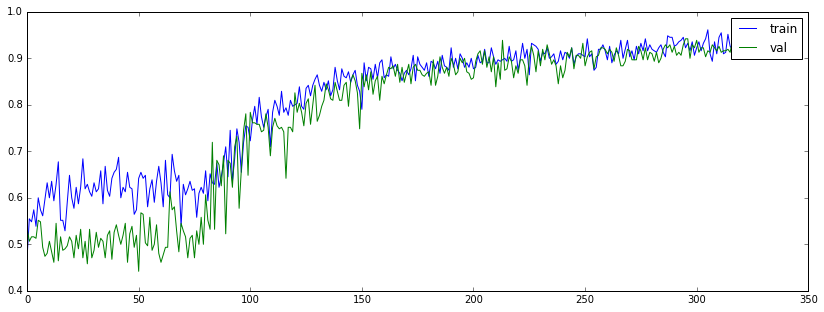

Train:
	loss: 0.0913696349553
	acc: 0.967741935484
	auc: 0.987799234297
	ap@k: 1.0
Val:
	loss: 0.177419294744
	acc: 0.929032258065
	auc: 0.969946719947
	ap@k: 1.0


KeyboardInterrupt: 

In [85]:
from sklearn.metrics import roc_auc_score, accuracy_score
from IPython.display import clear_output

n_epochs = 10000
batch_size = 10
minibatches_per_epoch = 30

for i in range(n_epochs):
    if(i%2 == 0):
        clear_output()
        plt.figure(figsize = (14,5))
        plt.plot(to_plot_train, label = "train")
        plt.plot(to_plot_val, label = "val")
        plt.legend()
        plt.show()
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr.values,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:
            break
        loss,pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)
    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Train:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    to_plot_train.append(accuracy_score(epoch_y_true,epoch_y_pred>0.))
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_tr.values,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print "Val:"
    print '\tloss:',b_loss/b_c
    print '\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.)
    print '\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred)
    print '\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)
    print "=========================================="
    to_plot_val.append(accuracy_score(epoch_y_true,epoch_y_pred>0.))
    
    

In [86]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_tr.values,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

Scores:
	loss: 0.181230699363
	acc: 0.922352
	auc: 0.969429479237
	ap@k: 0.995359577578

AUC:
	Сойдёт, хотя можно ещё поднажать (ok)

Accuracy:
	Всё ок (ok)

Average precision at K:
	Засабмить на kaggle! (great) 
	 Нет, ну честно - выкачай avito_test.tsv, засабмить и скажи, что вышло.


# Ответы

1) Слой эмбединга нужен для того, чтобы отобразить инпут из дискретного пространства большой размерности в непрерывное пространство меньшей размерности. В нейросети мы пользуемся непрерывностью пространства, уменьшение размерности --- это вообще отлично: быстрее будет обучаться и, как мне кажется, немного поможет с переобучением.
2) RNN от LSTM отличается тем, LSTM содержит в себе вектор памяти, который она тренируется правильно обновлять на каждом шагу. Это позволяет LSTM лучше понимать связь между входами на большом временном расстоянии друг от друга. RNN же такой памятью не обладает, зато обладает проблемой затухающего градиента. Градиент текущего выхода по внутреннему состоянию, которое было несколько шагов назад, экспоненциально мал по модулю, что и объясняет неспособность улавливать длинные связи.
3) RNN делает вывод о текущем на основании, в том числе, предыдущего, то есть ловит зависимость от контекста. Сверточная сеть ищет шаблон во всех частях входа. Если мы анализируем последовательность, где следующий токен зависит от предыдущего, то, очевидно, первых подход лучше.